In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import os,sys, gc
import matplotlib.pyplot as plt
from scipy.stats import entropy
sys.path.append("/content/drive/My Drive/phd/")
sys.path.append("/content/drive/My Drive/phd/hsbm-occam")
from hsbmpy import get_max_available_L

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
algorithm = "topsbm"
directory='/content/drive/My Drive/phd/datasets/cancers/lung'
L = get_max_available_L(directory, algorithm)-1
os.chdir(directory)

In [39]:
label = 'cancer.type'

df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,L)).set_index('doc').drop('i_doc', axis=1)
df_words = pd.read_csv("%s/%s_level_%d_word-dist.csv"%(algorithm,algorithm,L), index_col=0)
df_words.index=[g[:15] for g in df_words.index]
df = pd.read_csv("mainTable.csv", index_col=0).reindex(index=df_words.index)
df = df.divide(df.sum(0),1).transpose().fillna(0)
df_files=pd.read_csv("files.dat", index_col=0)
df_topics.insert(0,'tissue', df_files.reindex(index=df_topics.index)[label])
df_topic_tissue = df_topics.groupby('tissue').mean()
df_files.replace("Discordant_LUSC","LUAD", inplace=True)
df_files.head()

,cases.0.submitter_id,cases.0.diagnoses.0.morphology,cases.0.diagnoses.0.primary_diagnosis,cases.0.diagnoses.0.tissue_or_organ_of_origin,cases.0.diagnoses.0.tumor_grade,cases.0.diagnoses.0.tumor_stage,cases.0.project.disease_type,cases.0.project.primary_site,cases.0.samples.0.longest_dimension,cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id,longest_dimension,cancer.type,Subtype_mRNA,Subtype_DNAmeth,Subtype_Integrative,Subtype_Selected
file_name,,,,,,,,,,,,,,,,
2d683c1f-3a48-4bb8-84f9-bad6347c008b.FPKM.txt.gz,TCGA-05-4249,8140/3,"Adenocarcinoma, NOS","Lower lobe, lung",not reported,stage ib,Lung Adenocarcinoma,Lung,1.4,TCGA-05-4249-01A-01R-1107-07,1.6666666666666667,LUAD,unknown,unknown,5,LUAD.5
780ab54f-9100-447b-ba9e-75480e7be3d9.FPKM.txt.gz,TCGA-05-4382,8255/3,Adenocarcinoma with mixed subtypes,"Upper lobe, lung",not reported,stage ib,Lung Adenocarcinoma,Lung,0.9,TCGA-05-4382-01A-01R-1206-07,1.6666666666666667,LUAD,unknown,unknown,6,LUAD.6
f8332a4b-0365-4732-a6b8-a3998872e24c.FPKM.txt.gz,TCGA-05-4384,8255/3,Adenocarcinoma with mixed subtypes,"Lower lobe, lung",not reported,stage iiia,Lung Adenocarcinoma,Lung,0.8,TCGA-05-4384-01A-01R-1755-07,1.6666666666666667,LUAD,unknown,low,1,LUAD.1
755f981f-f957-48ec-9779-cf9887e19ab0.FPKM.txt.gz,TCGA-05-4389,8255/3,Adenocarcinoma with mixed subtypes,"Upper lobe, lung",not reported,stage ia,Lung Adenocarcinoma,Lung,1.3,TCGA-05-4389-01A-01R-1206-07,1.6666666666666667,LUAD,unknown,unknown,2,LUAD.2
d0d7fae1-355e-4ada-a469-b69d59c1edfe.FPKM.txt.gz,TCGA-05-4390,8255/3,Adenocarcinoma with mixed subtypes,"Upper lobe, lung",not reported,stage ib,Lung Adenocarcinoma,Lung,1.8,TCGA-05-4390-01A-02R-1755-07,3.3333333333333335,LUAD,unknown,intermediate,2,LUAD.2


## NN based predictor

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution1D
from tensorflow.keras.losses import binary_crossentropy,mean_squared_error, categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.framework.graph_util import convert_variables_to_constants
from tensorflow.python.client.device_lib import list_local_devices
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import os,sys, gc
list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9299553261082148743, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8102609511250817742
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17582985237974989521
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11150726272
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14083790842829858822
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [50]:
df_labels=df_files.copy()
df_labels=df_labels.reindex(index=df_topics.index)

uniq = len(df_labels[label].unique())

X_train = df_topics.drop('tissue',1)
X_train = X_train.subtract(X_train.mean(0),1).divide(0.5*(X_train.max(0)-X_train.min(0)),1).values.astype(float) #SGD transform
Y_train = to_categorical(np.unique(df_labels[label], return_inverse=True)[1])
inputs = X_train.shape[1]

Y_train = np.argmax(Y_train, axis=-1)
uniq = 1
activation_func = "sigmoid"
lr = 0.01
momentum = 0.95
l1 = 0.01
l2 = 0.0001
loss=binary_crossentropy

classes=np.unique(df_labels[df_labels.index.isin(df.index)][label], return_inverse=True)[0]

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, random_state=42, train_size=0.8)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(326, 12) (326,) (82, 12) (82,)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                260       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________
None


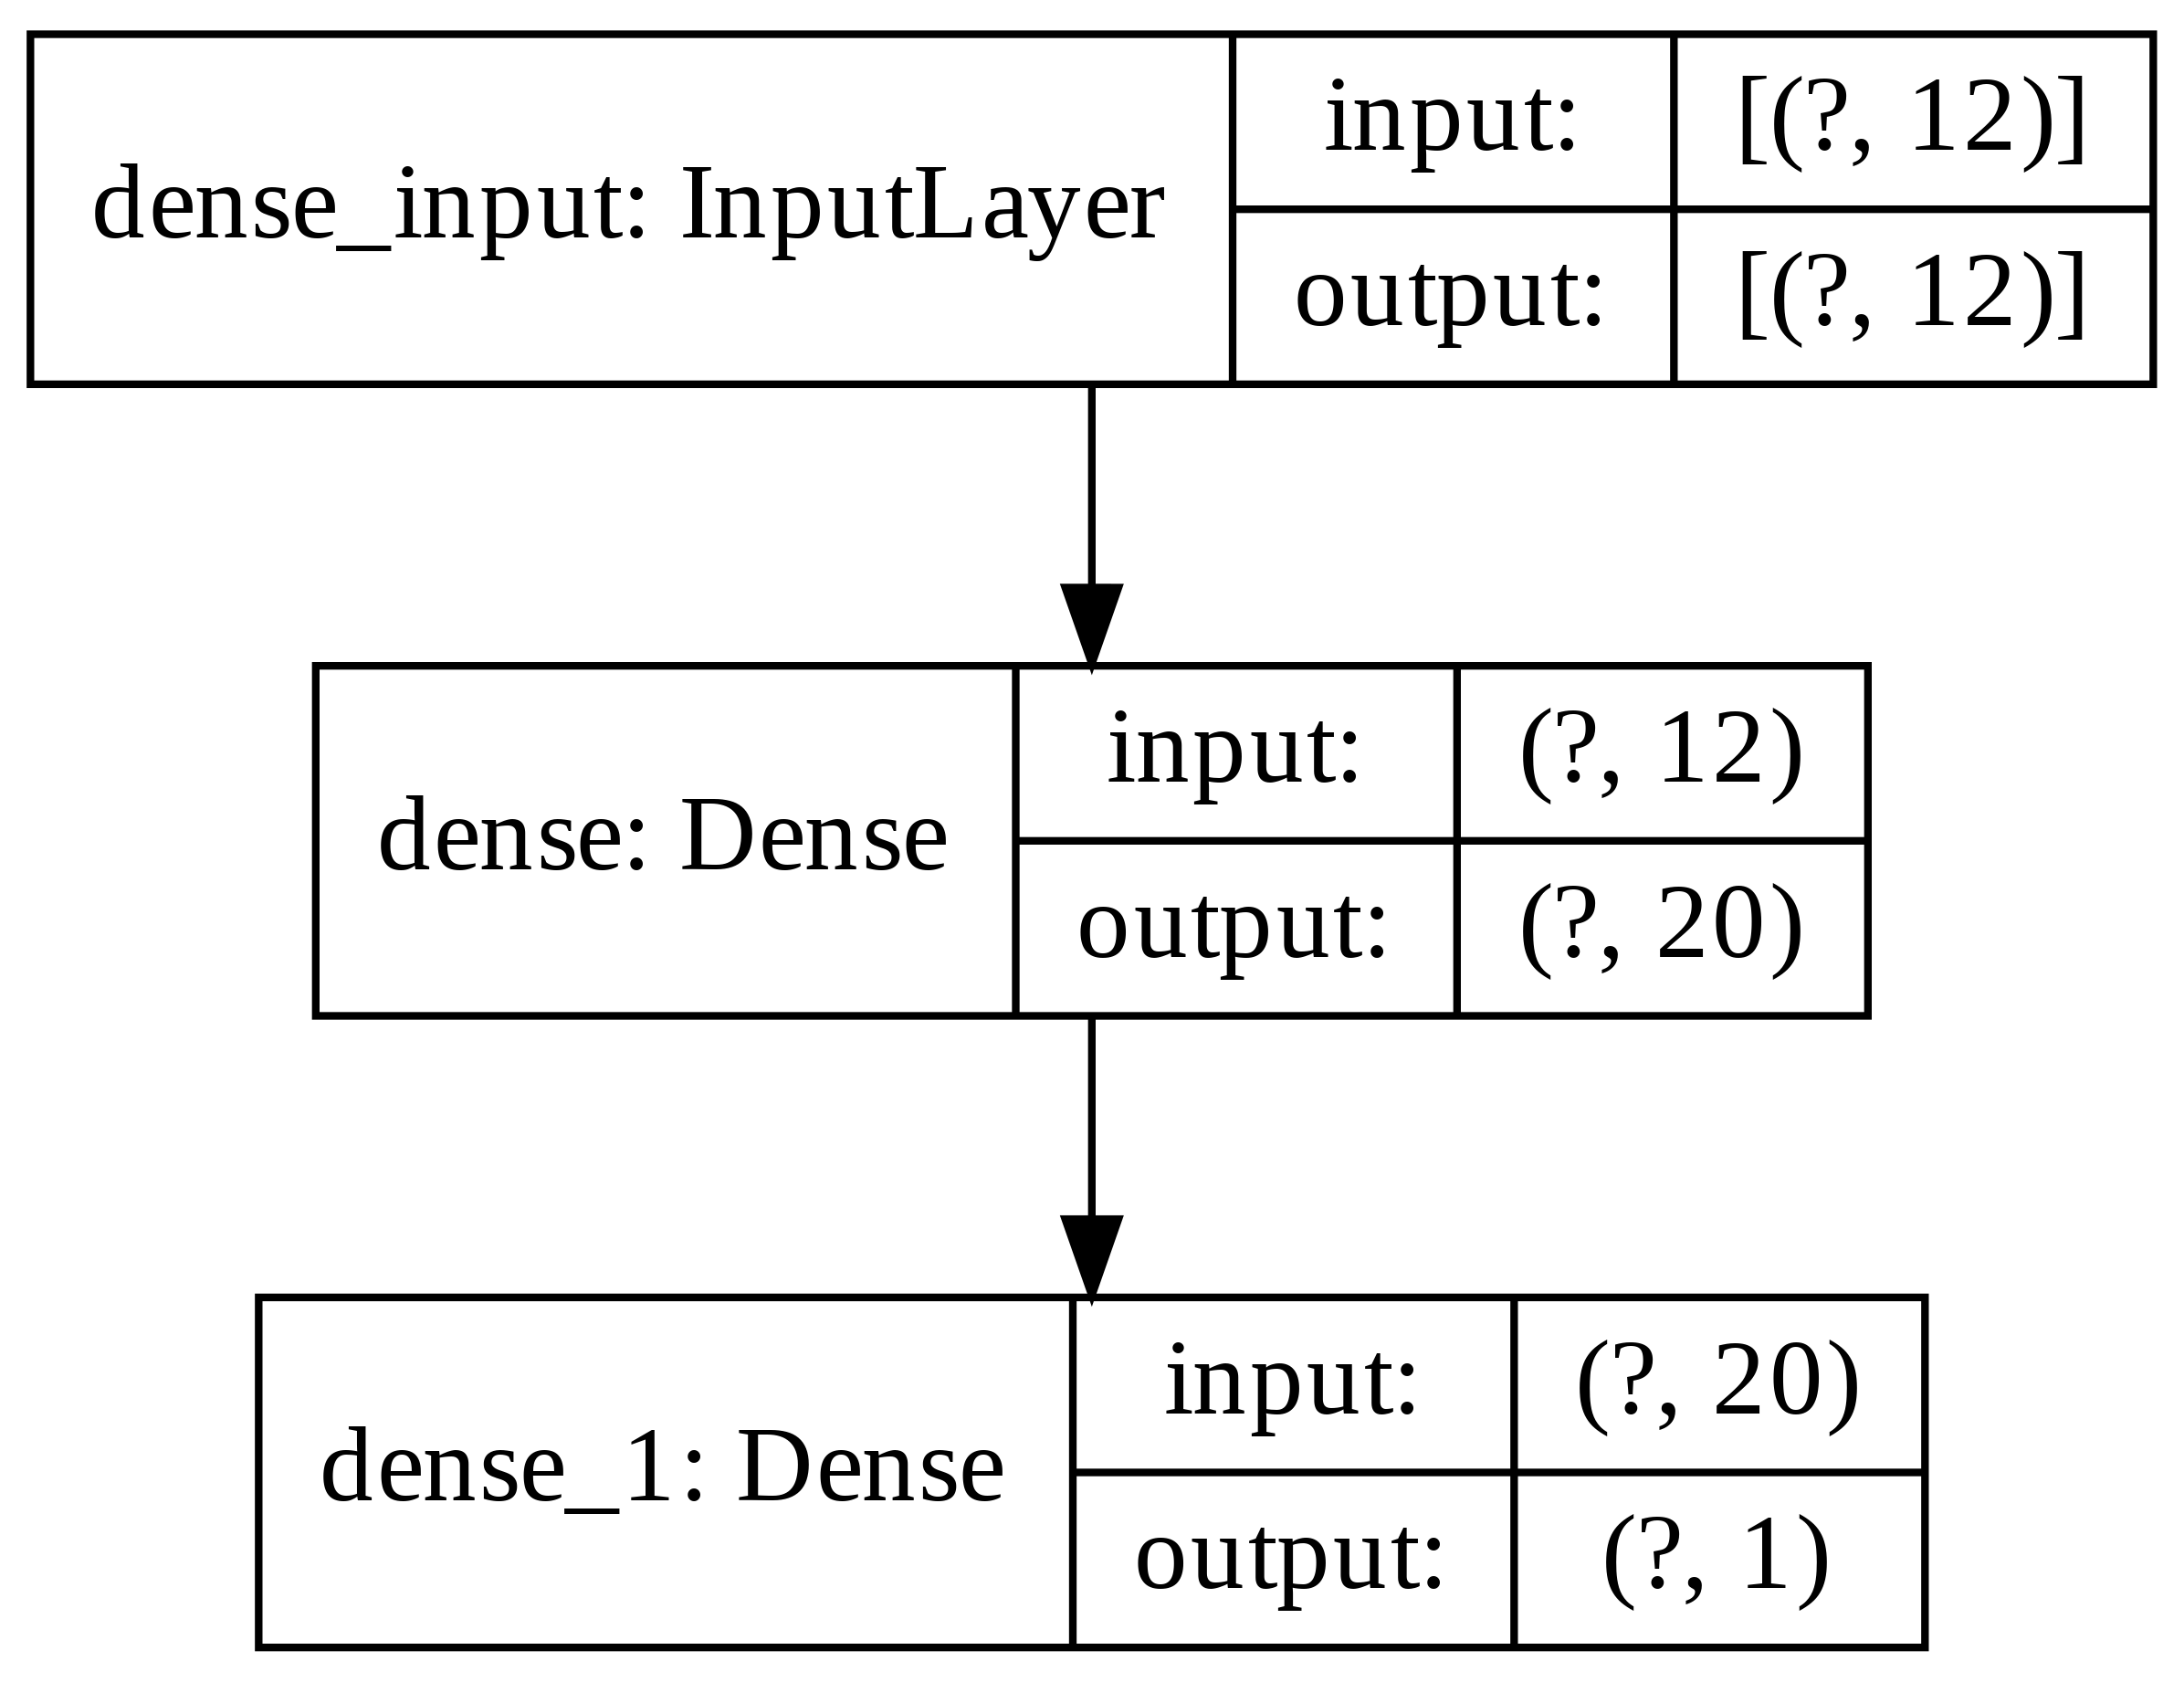

In [52]:
K.clear_session()

os.system("rm -rf log.csv")
csv_logger = CSVLogger('log.csv', append=True, separator=',')
es = EarlyStopping(monitor='val_loss', min_delta=1e-3, mode='min', patience=25)

model=Sequential()
model.add(Dense(units=20, input_dim=inputs, use_bias=True, bias_initializer="ones", activation="relu", kernel_regularizer=l1_l2(l1=l1, l2=l2)))
model.add(Dense(units=uniq, activation=activation_func))
model.compile(loss=loss, optimizer=SGD(lr=lr, momentum=momentum), metrics=['accuracy', 'AUC'])
K.set_learning_phase(0)

print(model.summary())
plot_model(model, to_file=f"model_{label}.png", dpi=600, show_shapes=True)


In [53]:
with tf.device("GPU"):
    model.fit(X_train, Y_train, epochs=1000, batch_size=50, verbose=1, validation_split=0.4, callbacks=[csv_logger, es], shuffle=True, use_multiprocessing=True, workers=-1)

Epoch 1/1000
4/4 [==============================] - 0s 78ms/step - loss: 1.0866 - accuracy: 0.7231 - auc: 0.9056 - val_loss: 1.0450 - val_accuracy: 0.8931 - val_auc: 0.9329
Epoch 2/1000
4/4 [==============================] - 0s 16ms/step - loss: 1.0273 - accuracy: 0.8103 - auc: 0.8948 - val_loss: 1.0180 - val_accuracy: 0.7786 - val_auc: 0.9211
Epoch 3/1000
4/4 [==============================] - 0s 18ms/step - loss: 1.0013 - accuracy: 0.7641 - auc: 0.9254 - val_loss: 1.0140 - val_accuracy: 0.6947 - val_auc: 0.9211
Epoch 4/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.9758 - accuracy: 0.7590 - auc: 0.9322 - val_loss: 0.9621 - val_accuracy: 0.7710 - val_auc: 0.9303
Epoch 5/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.9173 - accuracy: 0.8513 - auc: 0.9380 - val_loss: 0.8842 - val_accuracy: 0.8702 - val_auc: 0.9354
Epoch 6/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.8620 - accuracy: 0.8718 - auc: 0.9445 - val_loss: 0.8321 - v

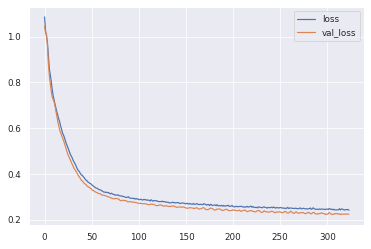

In [55]:
pd.read_csv("log.csv", sep=",")[['loss','val_loss']].plot()

In [56]:
model.evaluate(X_test, Y_test)

3/3 [==============================] - 0s 4ms/step - loss: 0.3379 - accuracy: 0.9268 - auc: 0.9483


[0.33791449666023254, 0.9268292784690857, 0.9482758045196533]

In [0]:
model.save(f"model_{label}.h5")
#model = load_model(f"model_{label}.h5")

In [58]:
gc.collect()

16898

# evaluate on non used on topsbm training


In [59]:
classes = df_files[label].unique()
print(X_test.shape, Y_test.shape)

(82, 12) (82,)


In [60]:
model.evaluate(X_test, Y_test, verbose=2, workers=-1, use_multiprocessing=True)

3/3 - 0s - loss: 0.3379 - accuracy: 0.9268 - auc: 0.9483


[0.33791449666023254, 0.9268292784690857, 0.9482758045196533]

In [0]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

In [0]:
y_pred_p = model.predict(X_test).ravel()
y_true = Y_test
y_pred = np.ones(y_pred_p.shape)
y_pred[y_pred_p<0.5]=0
results = confusion_matrix(y_true, y_pred, normalize="true")

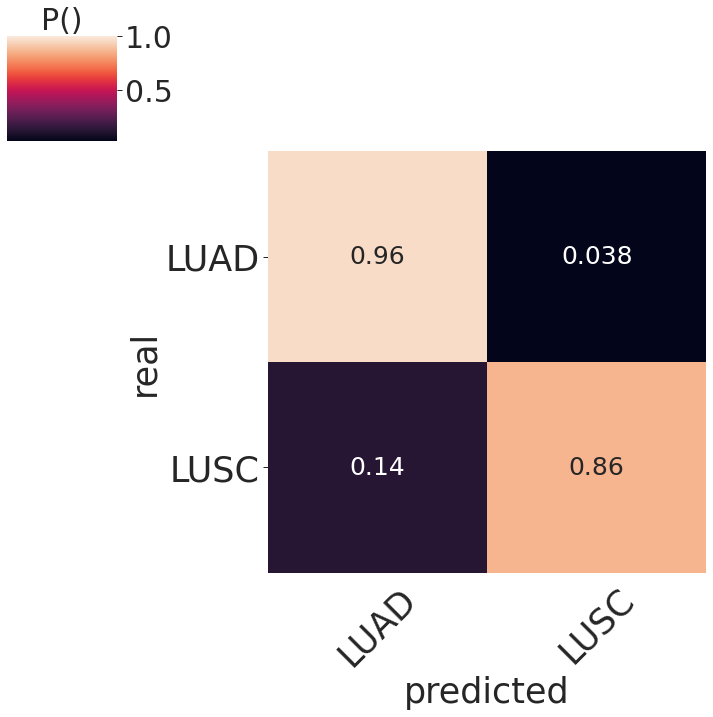

In [107]:
cm = sns.clustermap(results, 
                    vmax=1,  
                    row_cluster=False, 
                    col_cluster=False, 
                    xticklabels=classes, 
                    yticklabels=classes, 
                    annot=False,
                    annot_kws={"fontsize":25})
ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_ylabel("real", fontsize=35, rotation=90)
ax.set_yticklabels(labels=classes, rotation=0)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")

ax.set_xticklabels(labels=classes, rotation=45)
ax.set_xlabel("predicted",fontsize=35)
ax.tick_params(labelsize=35)

cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("P()", fontsize=30)
plt.tight_layout()
cm.savefig(f"predict_{label}.pdf")

plt.show()

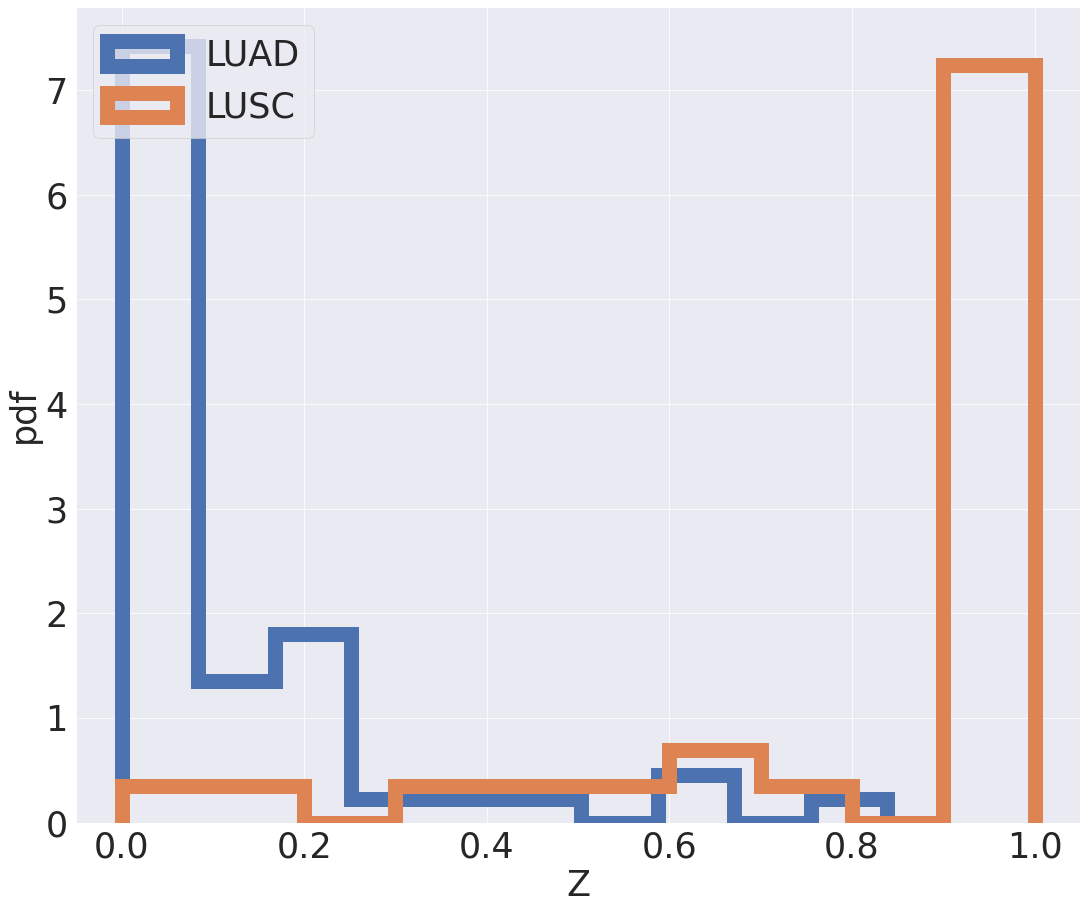

In [113]:
fig, ax= plt.subplots(figsize=(18,15))

ax.hist(y_pred_p[Y_test==0], histtype="step", lw=15, bins=10, density=True, label=classes[0])
ax.hist(y_pred_p[Y_test==1], histtype="step", lw=15, bins=10, density=True, label=classes[1])

ax.tick_params(labelsize=35)
ax.legend(fontsize=35, loc="upper left")
ax.set_title("", fontsize=35)

ax.set_xlim(-0.05,1.05)

ax.set_xlabel("Z", fontsize=35)
ax.set_ylabel("pdf", fontsize=35)

plt.show()

In [0]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_p)

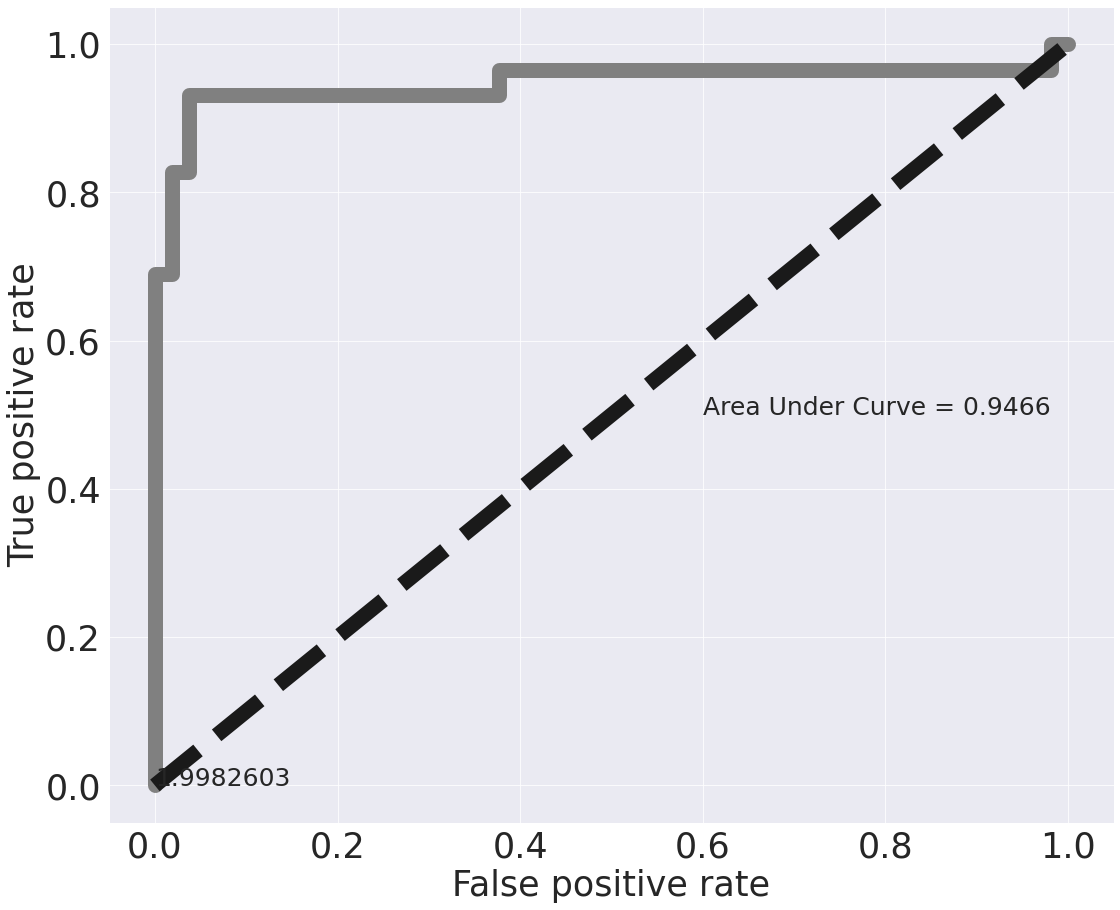

In [96]:
fig, ax = plt.subplots(figsize=(18,15))

ax.plot(fpr,tpr, c="gray", lw=15)

ax.plot([0, 1], [0, 1], 'k--', lw=15)
ax.set_xlabel('False positive rate', fontsize=35)
ax.set_ylabel('True positive rate', fontsize=35)


for f, t, thr in zip(fpr[::100], tpr[::100], thresholds[::100]):
    ax.annotate(thr, (f, t), fontsize=25)

ax.annotate("Area Under Curve = %.4f"%roc_auc_score(y_true, y_pred_p), xy=(0.6, 0.5), fontsize=25)

ax.tick_params(labelsize=35)

plt.show()
fig.savefig(f"roc_{label}.pdf")

# logistic regression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, auc

In [0]:
cv = KFold(n_splits=3)

param_grid = {"C":np.linspace(1,20,10)}
model = LogisticRegression(C=1., fit_intercept=True)

gs = GridSearchCV(model, param_grid, cv = cv, n_jobs=-1)

In [102]:
gs.fit(X_train, Y_train)
gs.best_params_

{'C': 11.555555555555555}

In [0]:
model = gs.best_estimator_

In [0]:
y_pred = model.predict(X_test)
y_pred_p = model.predict_proba(X_test).T[1]

In [101]:
accuracy_score(Y_test, y_pred)

0.926829268292683

In [105]:
fpr, tpr, thresholds = roc_curve(np.abs(y_true-1), y_pred_p.T[0])
auc(fpr, tpr)

0.9466493168510084